# Lab 2 - Exploring and manipulating data. 
Here is what we we do:
1. Read in the data from a CSV file and do simple visualizations
2. Look for patterns in the data
3. Deal with missing values
4. Add in new features
5. Split and graph

In [1]:
# imports

from pathlib import Path

import pandas as pd

### Read the CSV file:
We will use info() on the data frame to get a first look.  This is mostly a quick sanity check

In [5]:
import pandas as pd

# Properly parse semicolon-delimited file with quoted headers
howell_full = pd.read_csv("Howell.csv", sep=";", quotechar='"')

# Confirm columns loaded correctly
print(howell_full.columns)
howell_full.head()


Index(['height', 'weight', 'age', 'male'], dtype='object')


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


# Section 2. Data Exploration and Preparation

In [6]:
# From Lab 2

# Compute bmi based on height and weight metric units
def bmi(height, weight):
    return 10000 * weight / (height ** 2)

# New Feature
howell_full['bmi'] = bmi(howell_full['height'], howell_full['weight'])

import numpy as np

def bmi_category(value):
    # bmi can only be a single value
    if value < 18.5: return 'Underweight'
    if value < 25.0: return 'Normal'
    if value < 30.0: return 'Overweight'
    return 'Obese'

vector_bmi_category = np.vectorize(bmi_category)
howell_full['bmi class'] = vector_bmi_category(howell_full['bmi'])

# See distribution of the new categorical feature
howell_full['bmi class'].value_counts()


bmi class
Underweight    341
Normal         202
Overweight       1
Name: count, dtype: int64

In [8]:
# The following is an array of True/False
over18 = howell_full["age"] > 18

# Only keep the true instances to work with adults
howell_adults = howell_full[over18].copy()

# The not operator is ~ in numpy
howell_children = howell_full[~over18].copy()

print("Adults shape:", howell_adults.shape)
print("Children shape:", howell_children.shape)


Adults shape: (346, 6)
Children shape: (198, 6)


# Plot with Masking

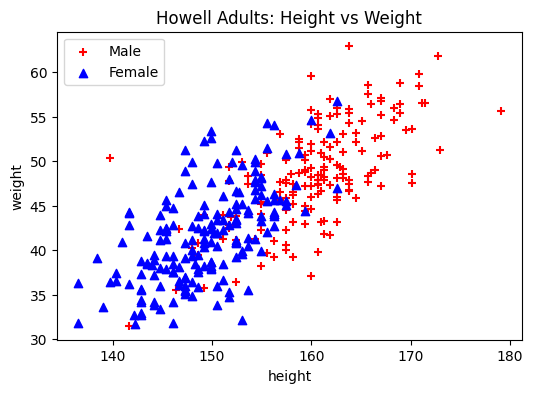

In [9]:
import matplotlib.pyplot as plt

# Create masks for male and female (male is 1 or 0)
male_height   = np.ma.masked_where(howell_adults['male'] == 0, howell_adults['height'])
female_height = np.ma.masked_where(howell_adults['male'] == 1, howell_adults['height'])
weight        = howell_adults['weight']

plt.figure(figsize=(6,4))
plt.scatter(male_height, weight,   c='red',  marker='+')
plt.scatter(female_height, weight, c='blue', marker='^')

plt.xlabel('height')
plt.ylabel('weight')
plt.legend(['Male', 'Female'])
plt.title('Howell Adults: Height vs Weight')
plt.show()


# Section 3. Feature Selection and Justification

## 3.1 Choose features and target
First:
Input features: Height
Target: Gender

Second:
Input features: Weight
Target: Gender

Third:
Input features: Height, Weight
Target: Gender

## Section 3.2 Define X (features) and y (target)

In [11]:
# Case 1: Height only
X = howell_adults[['height']]
y = howell_adults['male']

# Case 2: Weight only
# X = howell_adults[['weight']]
# y = howell_adults['male']

# Case 3: Height + Weight
# X = howell_adults[['height', 'weight']]
# y = howell_adults['male']

X.head(), y.head()


(    height
 0  151.765
 1  139.700
 2  136.525
 3  156.845
 4  145.415,
 0    1
 1    0
 2    0
 3    1
 4    0
 Name: male, dtype: int64)

Justification: Height and weight are likely to show clear patterns based on gender. Generally, males tend to have greater average height and weight compared to females. These two features together should strengthen prediction accuracy. By restricting the dataset to adults only, we reduce variability caused by age and growth, ensuring a more consistent relationship between these features and gender.

# Section 4. Train a Classification Model (Decision Tree)

## 4.1 Split the Data

In [13]:
# Split the data into training and test sets using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test  = y.iloc[test_indices]

print('Train size: ', len(X_train), '   Test size: ', len(X_test))


Train size:  276    Test size:  70


## 4.2 Train Model (Decision Tree)

In [14]:
# Create and train a decision tree model
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 4.3 Evaluate Model Performance

In [15]:
# Evaluate on training data
from sklearn.metrics import classification_report, accuracy_score

y_pred_train = tree_model.predict(X_train)
print("Results for Decision Tree on training data:")
print(classification_report(y_train, y_pred_train, digits=3))
print(f"Accuracy (train): {accuracy_score(y_train, y_pred_train):.3f}")

# Evaluate on test data
y_test_pred = tree_model.predict(X_test)
print("\nResults for Decision Tree on test data:")
print(classification_report(y_test, y_test_pred, digits=3))
print(f"Accuracy (test): {accuracy_score(y_test, y_test_pred):.3f}")


Results for Decision Tree on training data:
              precision    recall  f1-score   support

           0      0.863     0.959     0.908       145
           1      0.948     0.832     0.886       131

    accuracy                          0.899       276
   macro avg      0.906     0.895     0.897       276
weighted avg      0.903     0.899     0.898       276

Accuracy (train): 0.899

Results for Decision Tree on test data:
              precision    recall  f1-score   support

           0      0.786     0.892     0.835        37
           1      0.857     0.727     0.787        33

    accuracy                          0.814        70
   macro avg      0.821     0.810     0.811        70
weighted avg      0.819     0.814     0.813        70

Accuracy (test): 0.814


## 4.4 Report Confusion Matrix (as a heatmap)

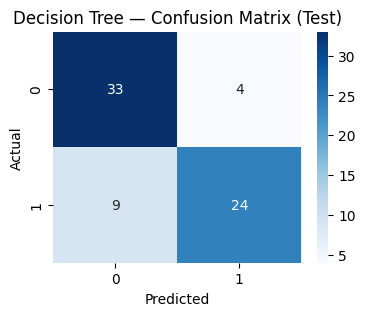

In [16]:
# Confusion matrix for test set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree — Confusion Matrix (Test)')
plt.show()


## 4.5 Report Decision Tree Plot

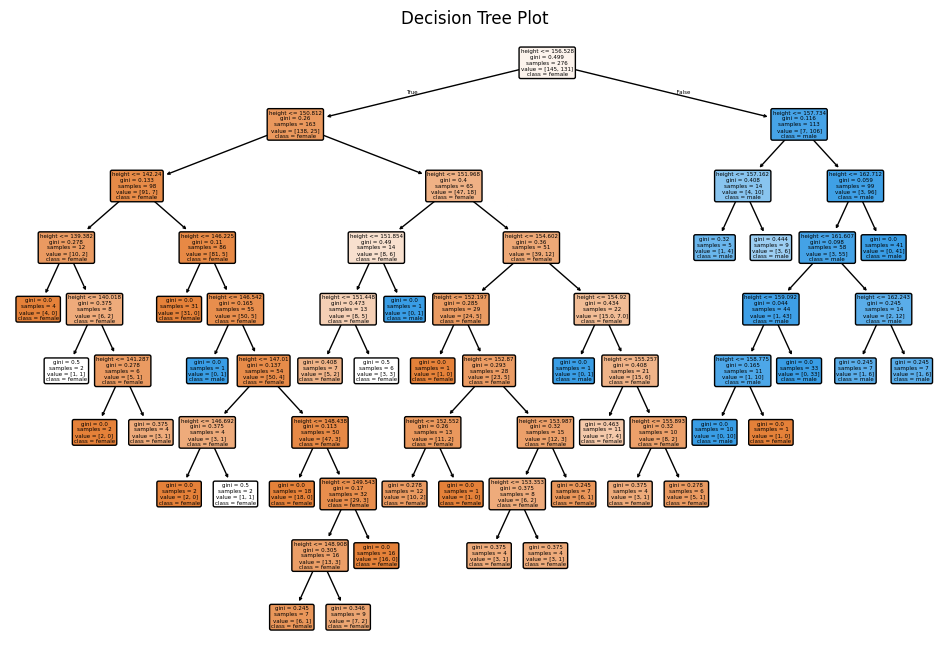

In [17]:
# Plot the Decision Tree (feature_names must match your current X from Section 3.2)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(tree_model,
          feature_names=list(X.columns),
          class_names=['female','male'],
          filled=True, rounded=True)
plt.title('Decision Tree Plot')
plt.show()


=== Decision Tree | Case 1 | Features: ['height'] ===
TRAIN
              precision    recall  f1-score   support

           0      0.863     0.959     0.908       145
           1      0.948     0.832     0.886       131

    accuracy                          0.899       276
   macro avg      0.906     0.895     0.897       276
weighted avg      0.903     0.899     0.898       276

Accuracy (train): 0.899

TEST
              precision    recall  f1-score   support

           0      0.786     0.892     0.835        37
           1      0.857     0.727     0.787        33

    accuracy                          0.814        70
   macro avg      0.821     0.810     0.811        70
weighted avg      0.819     0.814     0.813        70

Accuracy (test): 0.814


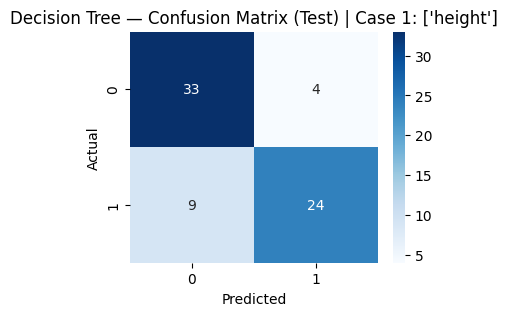


=== Decision Tree | Case 2 | Features: ['weight'] ===
TRAIN
              precision    recall  f1-score   support

           0      0.929     1.000     0.963       145
           1      1.000     0.916     0.956       131

    accuracy                          0.960       276
   macro avg      0.965     0.958     0.960       276
weighted avg      0.963     0.960     0.960       276

Accuracy (train): 0.960

TEST
              precision    recall  f1-score   support

           0      0.641     0.676     0.658        37
           1      0.613     0.576     0.594        33

    accuracy                          0.629        70
   macro avg      0.627     0.626     0.626        70
weighted avg      0.628     0.629     0.628        70

Accuracy (test): 0.629


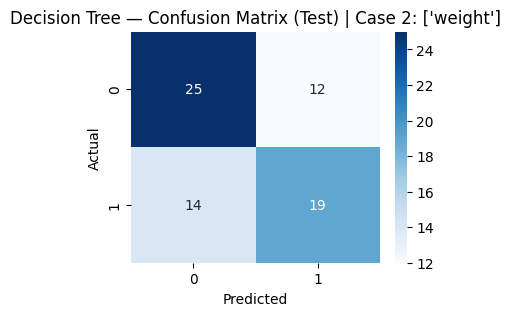


=== Decision Tree | Case 3 | Features: ['height', 'weight'] ===
TRAIN
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       145
           1      1.000     1.000     1.000       131

    accuracy                          1.000       276
   macro avg      1.000     1.000     1.000       276
weighted avg      1.000     1.000     1.000       276

Accuracy (train): 1.000

TEST
              precision    recall  f1-score   support

           0      0.718     0.757     0.737        37
           1      0.710     0.667     0.688        33

    accuracy                          0.714        70
   macro avg      0.714     0.712     0.712        70
weighted avg      0.714     0.714     0.714        70

Accuracy (test): 0.714


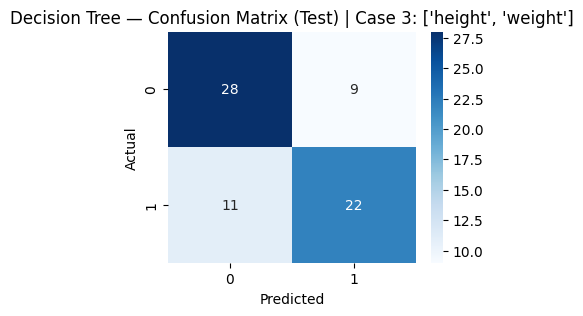


=== Summary (Decision Tree) ===


,Case,Features,Train Accuracy,Test Accuracy
0,1,height,0.899,0.814
1,2,weight,0.960,0.629
2,3,"height, weight",1.000,0.714


In [18]:
# ===== Run Decision Tree for ALL 3 CASES (Height | Weight | Height+Weight) =====
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def get_case_data(case_id):
    if case_id == 1:
        feats = ['height']
    elif case_id == 2:
        feats = ['weight']
    else:
        feats = ['height', 'weight']
    X = howell_adults[feats]
    y = howell_adults['male']
    return X, y, feats

summary_rows = []

for case in (1, 2, 3):
    # Select features/target
    X, y, feats = get_case_data(case)

    # Stratified split
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train Decision Tree
    tree_model = DecisionTreeClassifier(random_state=123)
    tree_model.fit(X_train, y_train)

    # Predict
    y_pred_train = tree_model.predict(X_train)
    y_pred_test  = tree_model.predict(X_test)

    # Metrics
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test  = accuracy_score(y_test,  y_pred_test)

    print(f"\n=== Decision Tree | Case {case} | Features: {feats} ===")
    print("TRAIN")
    print(classification_report(y_train, y_pred_train, digits=3))
    print(f"Accuracy (train): {acc_train:.3f}")
    print("\nTEST")
    print(classification_report(y_test, y_pred_test, digits=3))
    print(f"Accuracy (test): {acc_test:.3f}")

    # Confusion Matrix (test)
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'Decision Tree — Confusion Matrix (Test) | Case {case}: {feats}')
    plt.show()

    # Save to summary
    summary_rows.append({
        "Case": case,
        "Features": ", ".join(feats),
        "Train Accuracy": round(acc_train, 3),
        "Test Accuracy":  round(acc_test,  3)
    })

# Compact summary table
summary_df = pd.DataFrame(summary_rows)
print("\n=== Summary (Decision Tree) ===")
display(summary_df)


# Section 5. Compare Alternative Models (SVC, NN)

## 5.1 Train Support Vector Classifier (SVC) Model

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Case 3: Height + Weight
X = howell_adults[['height', 'weight']]
y = howell_adults['male']

# Split the data
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test  = y.iloc[test_indices]

# Train the SVC model
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=123)
svc_model.fit(X_train, y_train)

# Predict and evaluate SVC model
y_pred_svc = svc_model.predict(X_test)

print("Results for SVC on test data:")
print(classification_report(y_test, y_pred_svc, digits=3))


Results for SVC on test data:
              precision    recall  f1-score   support

           0      0.784     0.784     0.784        37
           1      0.758     0.758     0.758        33

    accuracy                          0.771        70
   macro avg      0.771     0.771     0.771        70
weighted avg      0.771     0.771     0.771        70



### Graph the Support Vectors

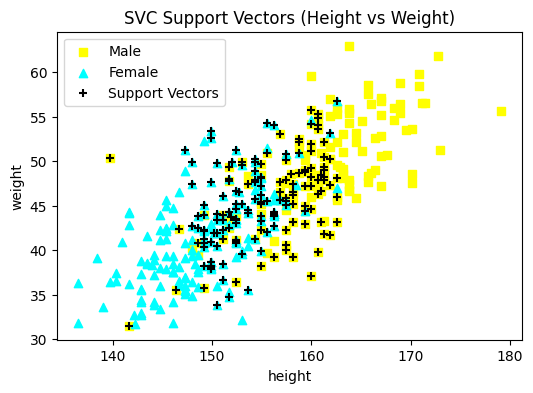

In [20]:
# get the values for the support vectors (the special instances)
support_x = [x for (x, y) in svc_model.support_vectors_]
support_y = [y for (x, y) in svc_model.support_vectors_]

# Create male/female masks
male_mask   = howell_adults['male'] == 1
female_mask = howell_adults['male'] == 0

plt.figure(figsize=(6, 4))
plt.scatter(howell_adults.loc[male_mask, 'height'], howell_adults.loc[male_mask, 'weight'], c='yellow', marker='s', label='Male')
plt.scatter(howell_adults.loc[female_mask, 'height'], howell_adults.loc[female_mask, 'weight'], c='cyan', marker='^', label='Female')
plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors')

plt.xlabel('height')
plt.ylabel('weight')
plt.legend()
plt.title('SVC Support Vectors (Height vs Weight)')
plt.show()


## 5.2 Train a Neural Network (NN) Model

In [21]:
from sklearn.neural_network import MLPClassifier

# Neural network with 3 hidden layers
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs',
                         max_iter=500,
                         random_state=123)
nn_model.fit(X_train, y_train)

# Predict and evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)

print("Results for Neural Network on test data:")
print(classification_report(y_test, y_pred_nn, digits=3))


Results for Neural Network on test data:
              precision    recall  f1-score   support

           0      0.789     0.811     0.800        37
           1      0.781     0.758     0.769        33

    accuracy                          0.786        70
   macro avg      0.785     0.784     0.785        70
weighted avg      0.786     0.786     0.785        70



## Plot Confusion Matrix (Neural Network)

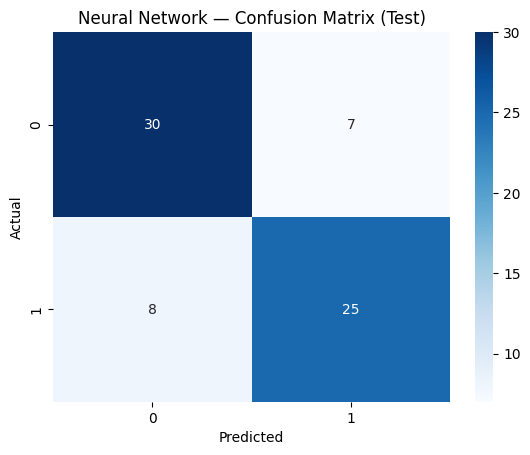

In [22]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network — Confusion Matrix (Test)')
plt.show()
